In [14]:
%pylab inline
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE184426
counts = pd.read_table("./GSE184426_ExP_1Kx1K_counts.txt.gz")
counts.head()

,BC,promoter,enhancer,DNA_input,reads_rep1,reads_rep2,reads_rep3,reads_rep4,weighted_reads_rep1,weighted_reads_rep2,weighted_reads_rep3,weighted_reads_rep4
0,AAAAAAAAAAAATAA,scramble941-promoter,chr17:31236973-31237237-enhancer,12,0,0,0,0,0,0,0,0
1,AAAAAAAAAAATCGG,chr7:132937608-132937872-promoter,chrX:48904635-48904899-enhancer,104,2,0,1,0,2,0,2,0
2,AAAAAAAAAACATTC,chr2:61404378-61404642-promoter,chr12:93273507-93273771-enhancer,26,3,0,1,1,4,0,1,2
3,AAAAAAAAAACTGGT,chr4:109541510-109541774-promoter,scramble949-enhancer,143,38,28,30,36,47,46,48,63
4,AAAAAAAAAAGAATT,chr2:220109978-220110242-promoter,chr1:226190554-226190818-enhancer,178,0,0,0,0,0,0,0,0


In [39]:
# use wieghted counts - balanced for total counts to be approximately equal across reps
counts['RNA'] = counts['weighted_reads_rep1	weighted_reads_rep2	weighted_reads_rep3	weighted_reads_rep4'.split()].sum(axis=1)

# filter to at least 25 DNA reads (for noise), and one RNA read (to avoid technical dropouts)
counts = counts.query("(DNA_input >= 25) & (RNA >= 1)").copy()
counts['score'] = np.log2(counts.RNA) - np.log2(counts.DNA_input)


## MLE estimate of promoter & enhancer strengths

In [20]:
def mle_poisson(cts, niters=5):
    # log2 strength of promoters and enhancers
    promoter_strengths = pd.Series(index=counts.promoter.unique(), data=0)
    enhancer_strengths = pd.Series(index=counts.enhancer.unique(), data=0)
    
    # predict from a limited set of factors
    def current_prediction(estimated_strengths):
        return cts.DNA_input * 2 ** (estimated_strengths)

    for it in range(niters + 1):
        # recompute predicted
        predicted = current_prediction(cts.promoter.map(promoter_strengths) +
                                       cts.enhancer.map(enhancer_strengths))
        loglik = counts.RNA * np.log(predicted) - predicted
        print(f"iter: {it}  log: {loglik.mean()}")
        if (it == niters):
            # print loglikelihood after last iteration
            break
        
        # re-estimate promoter strength
        # predict from only enhancers
        cts['e_predicted'] = current_prediction(cts.enhancer.map(enhancer_strengths))
        prom_groups = cts.groupby("promoter")
        RNA_by_promoter = prom_groups.RNA.sum()
        predicted_by_promoter = prom_groups.e_predicted.sum()
        # MLE estimate of promoter strength is log of sum(observed RNA) / sum(predicted RNA)
        promoter_strengths = np.log2(RNA_by_promoter) - np.log2(predicted_by_promoter)
        
        # re-estimate enhancer strength
        # predict from only promoters
        cts['p_predicted'] = current_prediction(cts.promoter.map(promoter_strengths))
        enh_groups = cts.groupby("enhancer")
        RNA_by_enhancer = enh_groups.RNA.sum()
        predicted_by_enhancer = enh_groups.p_predicted.sum()
        # MLE estimate of promoter strength is log of sum(observed RNA) / sum(predicted RNA)        
        enhancer_strengths = np.log2(RNA_by_enhancer) - np.log2(predicted_by_enhancer)
        
        # The steps above can be extended to other per-plasmid features, such as cluster
        # labels, using current_prediction() with the sum of 
        # promoter/enhancer/cluster/etc. strengths excluding just the current
        # feature strength being estimated.
        
    # adjusting to set promoter and enhancer BG fragments to 0:
    # - shift promoter strengths so mean of BG is 0
    # - shift enhancer strengths so mean of BG is 0
    # - intercept is negative sum of P/E shifts
    
    return promoter_strengths, enhancer_strengths

In [21]:
promoter_strengths, enhancer_strengths = mle_poisson(counts)

iter: 0  log: 1821.4762216027245
iter: 1  log: 2205.5772109182767
iter: 2  log: 2205.7333303909622
iter: 3  log: 2205.7333318104475
iter: 4  log: 2205.7333318105084
iter: 5  log: 2205.7333318105107


## per-plasmid correlation

R = 0.7496041382373845


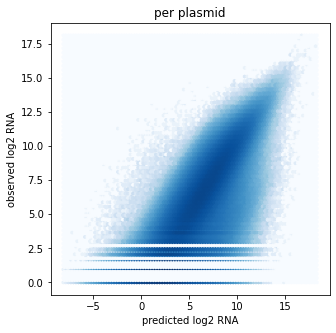

In [48]:
figure(figsize=(5, 5))
hexbin(np.log2(counts.DNA_input *
               2 ** (counts.promoter.map(promoter_strengths) +
                     counts.enhancer.map(enhancer_strengths))),
       np.log2(counts.RNA),
       bins='log',
       cmap='Blues')
title('per plasmid')
xlabel('predicted log2 RNA')
ylabel('observed log2 RNA')
print("R =", pearsonr(np.log2(counts.DNA_input *
                              2 ** (counts.promoter.map(promoter_strengths) +
                                    counts.enhancer.map(enhancer_strengths))),
                      np.log2(counts.RNA))[0])

## per-pair correlation

R= 0.9037275405903746


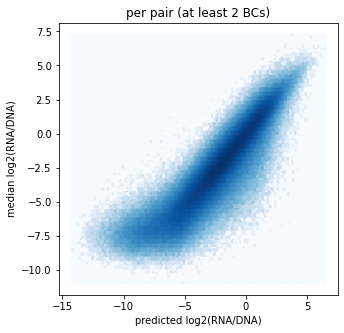

In [50]:
p_e_groups = counts.groupby("promoter enhancer".split())
sizes = p_e_groups.size()
group_scores = p_e_groups.score.median()[sizes >= 2]
group_scores = group_scores.reset_index()
group_scores.head()

figure(figsize=(5, 5))
hexbin(group_scores.promoter.map(promoter_strengths) + group_scores.enhancer.map(enhancer_strengths),
       group_scores.score,
       bins='log', cmap='Blues')
title('per pair (at least 2 BCs)')
xlabel('predicted log2(RNA/DNA)')
ylabel('median log2(RNA/DNA)')
print("R=", pearsonr(group_scores.promoter.map(promoter_strengths) +
                     group_scores.enhancer.map(enhancer_strengths),
                     group_scores.score)[0])